**In this notebook you will find the code that performs the preprocessing of pulsar data, solar and geomagnetic parameters for chosen pulsar. As a result of executing the code, you will get a dataset ready for experiments**

### Import the libraries and download the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import os
import torch

from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from tqdm import tqdm
from IPython.display import clear_output
from scipy.io import netcdf

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
!gdown -O J0332_auroral.txt 1IPH99N4U8gEIT6zPjsIti29M7iK3szzW
!gdown -O J0332_time_series.txt 1fexlMUUCyhK68NvJGqnKKuN2olbJo0F7
!gdown -O J0332_geosolar.txt 1f6NsqO4fb9bUO3g4abdbhw64qGG18RkD

Downloading...
From: https://drive.google.com/uc?id=1IPH99N4U8gEIT6zPjsIti29M7iK3szzW
To: /content/J0332_auroral.txt
100% 92.7k/92.7k [00:00<00:00, 60.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fexlMUUCyhK68NvJGqnKKuN2olbJo0F7
To: /content/J0332_time_series.txt
100% 152k/152k [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f6NsqO4fb9bUO3g4abdbhw64qGG18RkD
To: /content/J0332_geosolar.txt
100% 120k/120k [00:00<00:00, 64.7MB/s]


### Collect all the parts of the dataset

In [3]:
puls_name = "J0332" #"J0814", "J1921"

Length of time series: 1962


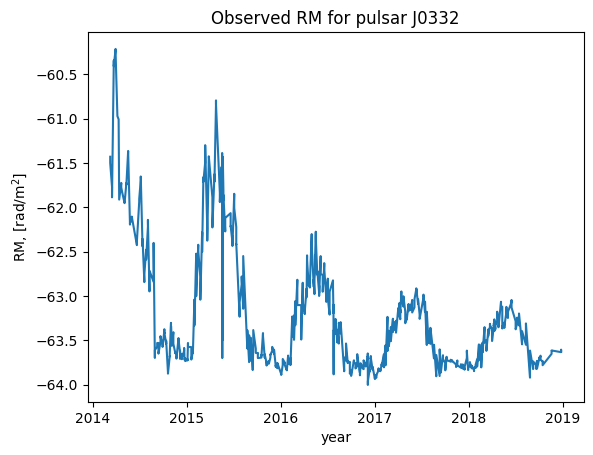

In [4]:
mjd_pulsar = []
rm_ion = []
obs_rm = []
rm_err = []
VTEC = []
Bpar = []
ele = []

with open(puls_name+"_time_series.txt", 'r') as f:
    text = f.readlines()
    for elem in text[1:]:
        s = elem.split()
        if s:
            mjd_pulsar.append(float(s[0]))
            rm_ion.append(float(s[1]))
            obs_rm.append(float(s[2]))
            rm_err.append(float(s[3]))
            VTEC.append(float(s[5]))
            Bpar.append(float(s[6]))
            ele.append(float(s[7]))

mjd_pulsar = np.array(mjd_pulsar)
rm_ion = np.array(rm_ion)
obs_rm = np.array(obs_rm)
VTEC = np.array(VTEC)
Bpar = np.array(Bpar)
ele = np.array(ele)

time_tmp = Time(mjd_pulsar, format = 'mjd')
time_tmp.format = 'decimalyear'
time_pulsar = time_tmp.value

print("Length of time series:", len(time_pulsar))

plt.plot(time_pulsar, obs_rm)
plt.xlabel("year")
plt.ylabel(r"RM, [rad/m$^2$]")
plt.title("Observed RM for pulsar "+puls_name)
plt.show()

In [35]:
if puls_name == "J0332":
    pulsar_coords_eq = SkyCoord(ra='3h32m59.368s', dec='54d34m43.57s', frame='icrs') #J0332+5434

elif puls_name == "J0814":
    pulsar_coords_eq = SkyCoord(ra='8h14m59.50s', dec='74d29m05.70s', frame='icrs') #J0814+7429

elif puls_name == "J1921":
    pulsar_coords_eq = SkyCoord(ra='19h21m44.815s', dec='21d53m02.25s', frame='icrs') #J1921+2153

#LOFAR de695 coordinates
latitude = '50d55m0.00s'
longitude = '6d21m00.0s'
observing_location = EarthLocation.from_geodetic(lat=latitude, lon=longitude, height = 0)

R = 6371
time_decimal_year = Time(time_pulsar, format='decimalyear')
pulsar_altaz = pulsar_coords_eq.transform_to(AltAz(obstime=time_decimal_year, location=observing_location))
z = np.array(pulsar_altaz.zen.radian)

In [6]:
auroral = pd.read_csv(puls_name+"_auroral.txt", sep=' ', names=['SML', 'SMU', 'SMR'])

In [7]:
dataset = pd.read_csv(puls_name+"_geosolar.txt", sep=' ', names=['X-ray B', 'SYM-H', 'F10.7', 'LST'])

In [8]:
dataset['SML'] = auroral['SML']
dataset['SMU'] = auroral['SMU']
dataset['SMR'] = auroral['SMR']

dataset['time'] = time_pulsar
dataset['VTEC'] = VTEC
dataset['Bpar'] = Bpar
dataset['z'] = z

### Preprocess RM time series

#### Subtract the ISM

We consider the value of the measure of rotation of the interstellar medium (ISM) to be constantand find its value as the average value of the observed rotation measure after subtracting the influence of the ionosphere in the first approximation, which in turn is calculated using the single layer ionosphere model

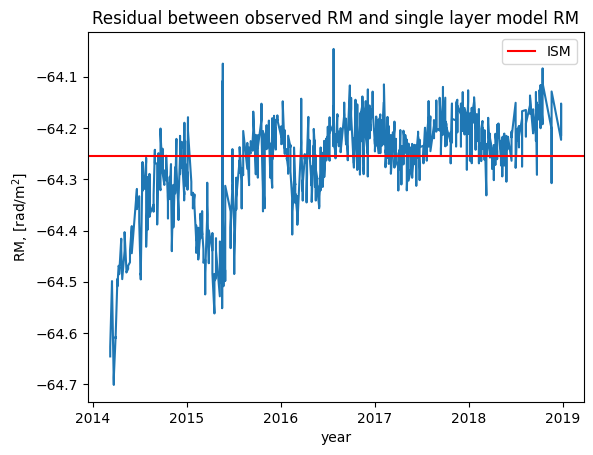

In [9]:
residual = np.array(obs_rm) - np.array(rm_ion)
ISM = np.mean(residual)

plt.plot(time_pulsar, residual)
plt.axhline(ISM, label="ISM", color='red')
plt.legend()
plt.ylabel(r"RM, [rad/m$^2$]")
plt.xlabel("year")
plt.title("Residual between observed RM and single layer model RM")
plt.show()

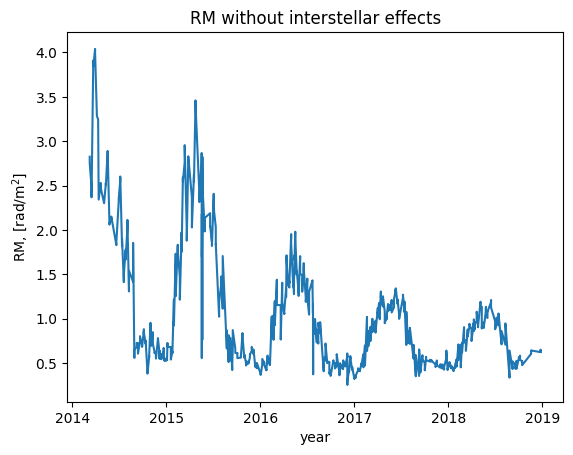

In [10]:
rm_iono_only = obs_rm - ISM

plt.plot(time_pulsar, rm_iono_only)
plt.ylabel(r"RM, [rad/m$^2$]")
plt.xlabel("year")
plt.title("RM without interstellar effects")
plt.show()

#### Compute target values

In [11]:
compiled_target1 = []
for i in tqdm(range(len(time_pulsar))):
    sin_z = np.sin(z[i])
    compiled1 = (Bpar[i] * VTEC[i]*2.62e-6/rm_iono_only[i])**2
    compiled_target1.append(compiled1)
compiled_target1 = np.array(compiled_target1)

100%|██████████| 1962/1962 [00:00<00:00, 209982.76it/s]


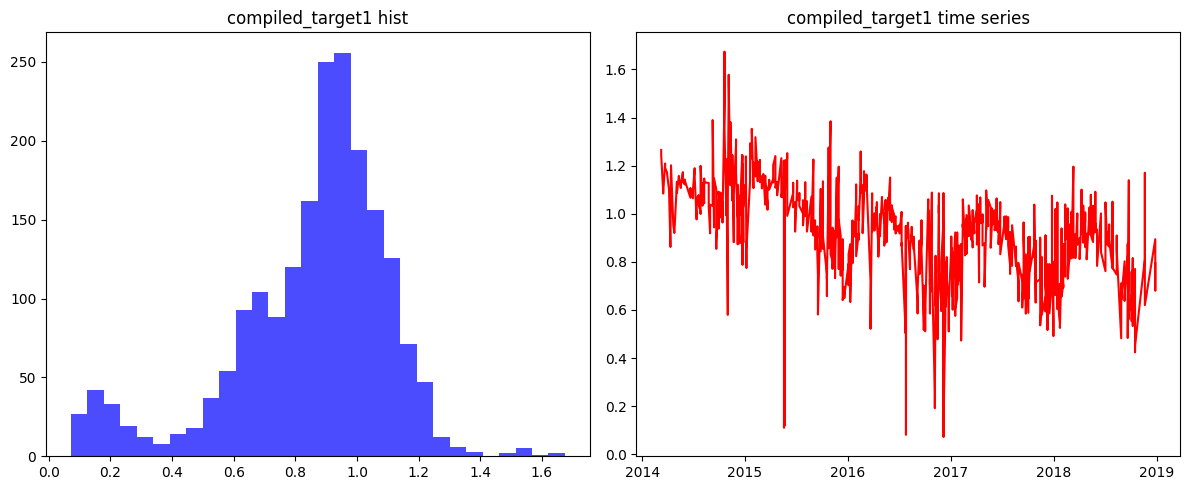

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(compiled_target1, bins=30, color='blue', alpha=0.7)
axs[0].set_title('compiled_target1 hist')

axs[1].plot(time_pulsar, compiled_target1, color='red')
axs[1].set_title('compiled_target1 time series')

plt.tight_layout()
plt.show()

Let's see how RM recovered from target1 looks like:

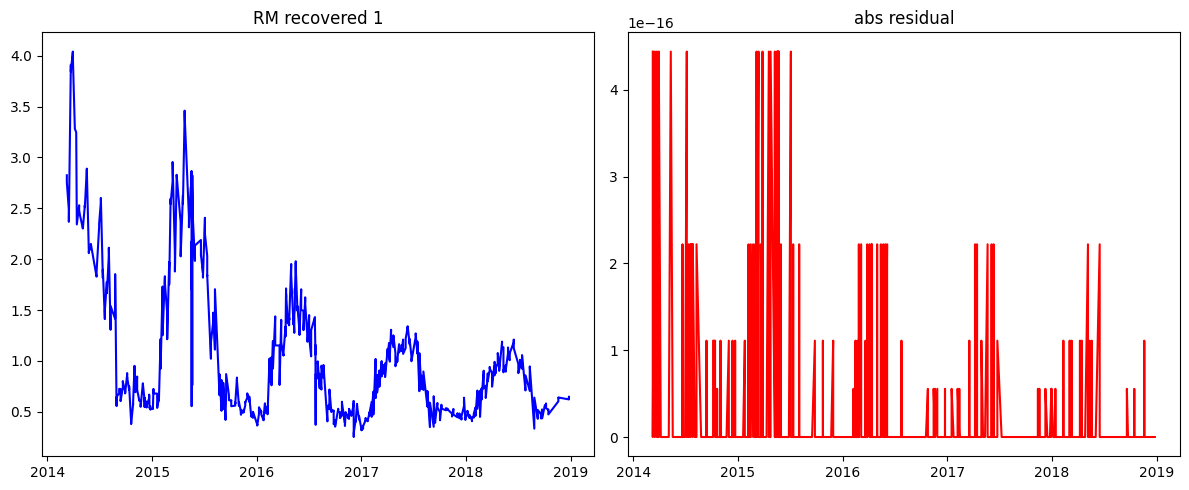

In [13]:
rm_recovered1  = Bpar*VTEC*2.62e-6/(compiled_target1)**0.5

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(time_pulsar, rm_recovered1, color='blue')
axs[0].set_title('RM recovered 1')

axs[1].plot(time_pulsar, np.abs(rm_recovered1 - rm_iono_only), color='red')
axs[1].set_title('abs residual')

plt.tight_layout()
plt.show()

In [14]:
dataset['target1'] = compiled_target1

#### Study the instability

This little experiment shows how the noise in RM values affects the H_eff values. 450 km is the equilibrium value determined by the standard single layer model. One can clearly see that even a small amount of noise makes H_eff unstable

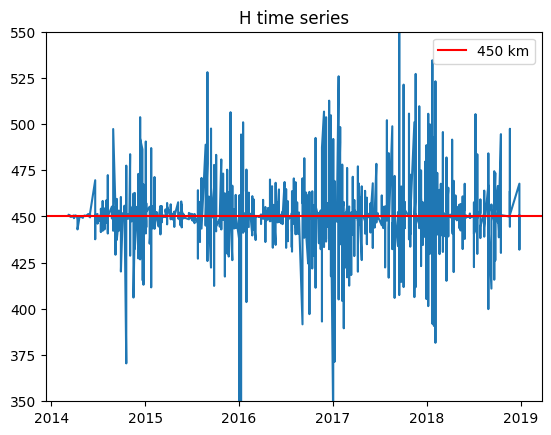

In [15]:
alpha = 1e-5 #feel free to change this value
RM_computed  = Bpar*VTEC*2.62e-6/(1 - (R*np.sin(z)/(R+450.))**2)**0.5 + alpha*np.random.randn(len(Bpar))
H = R*np.sin(z)/(1 - (np.array(Bpar)*np.array(VTEC)*2.62e-6/RM_computed)**2)**0.5 - R

plt.plot(time_pulsar, H)
plt.axhline(450, label='450 km', color='red')
plt.title("H time series")
plt.ylim(350, 550)
plt.legend()
plt.show()

Now let's look at the instability of target1:

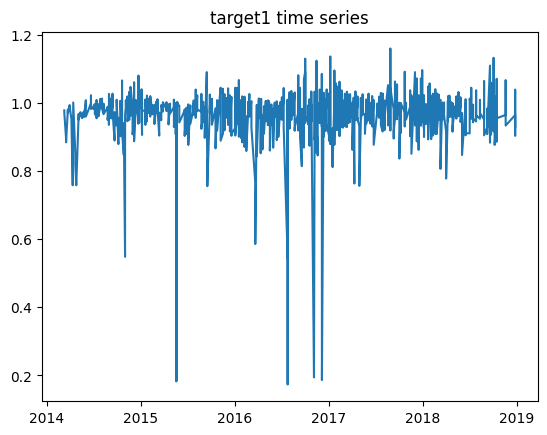

In [16]:
alpha = 1e-2 #feel free to change this value
RM_computed  = Bpar*VTEC*2.62e-6/(1 - (R*np.sin(z)/(R+450.))**2)**0.5 + alpha*np.random.randn(len(Bpar))
target1_computed = (np.array(Bpar)*np.array(VTEC)*2.62e-6/RM_computed)**2

plt.plot(time_pulsar, target1_computed)
plt.title("target1 time series")
plt.show()

Seems to be quite stable

#### Let's make the series homoscedastic

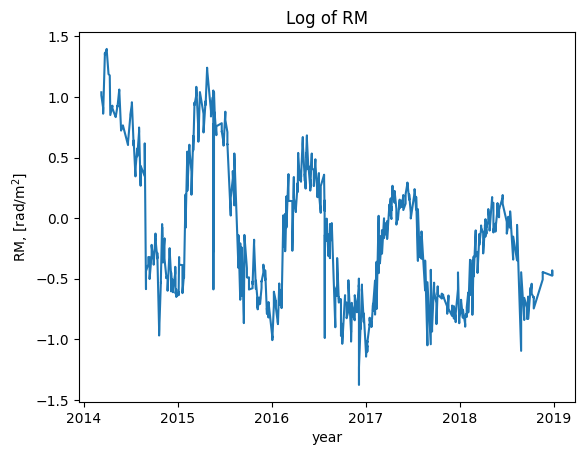

In [17]:
rm_iono_only_stat = np.log(rm_iono_only)

plt.plot(time_pulsar, rm_iono_only_stat)
plt.title("Log of RM")
plt.ylabel(r"RM, [rad/m$^2$]")
plt.xlabel("year")
plt.show()

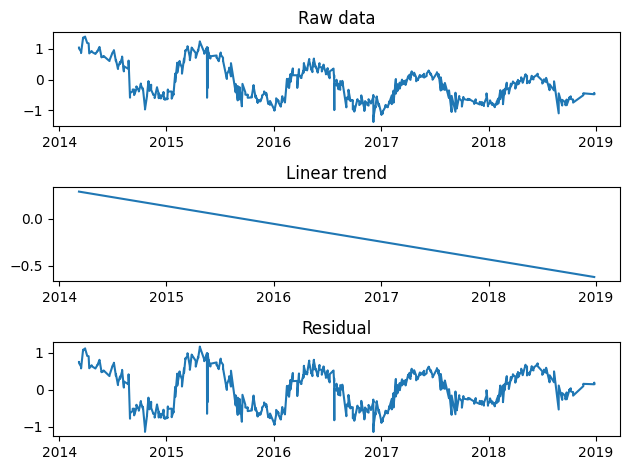

In [18]:
k, b = np.polyfit(time_pulsar, rm_iono_only_stat, 1)
trend = [k*x + b for x in time_pulsar]

fig, ax = plt.subplots(3, 1)

ax[0].plot(time_pulsar, rm_iono_only_stat)
ax[0].set_title("Raw data")

ax[1].plot(time_pulsar, trend)
ax[1].set_title("Linear trend")

ax[2].plot(time_pulsar, rm_iono_only_stat - trend)
ax[2].set_title("Residual")

plt.tight_layout()
plt.show()

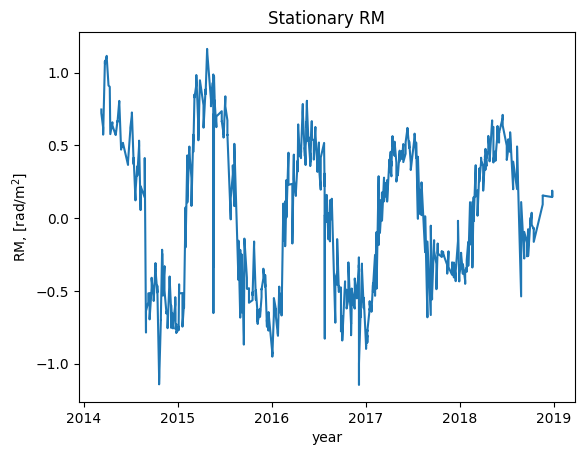

In [19]:
rm_iono_only_stat -= trend

plt.plot(time_pulsar, rm_iono_only_stat)
plt.title("Stationary RM")
plt.ylabel(r"RM, [rad/m$^2$]")
plt.xlabel("year")
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(rm_iono_only_stat)

print("adf: ", test[0])
print("p-value: ", test[1])

if test[0] > test[4]["5%"]:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

adf:  -3.89447635439653
p-value:  0.0020758762634589182
The time series is stationary


In [21]:
dataset['RM_real'] = rm_iono_only
dataset['RM_real_stat'] = rm_iono_only_stat

### Preprocess solar and geomagnetic features

In [22]:
pulsar_cols = ['time', 'RM_real', 'RM_real_stat', 'VTEC', 'Bpar', 'z', 'target1']
features_cols = [col for col in dataset.columns if col not in pulsar_cols]

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   X-ray B       1962 non-null   float64
 1   SYM-H         1962 non-null   float64
 2   F10.7         1962 non-null   float64
 3   LST           1962 non-null   float64
 4   SML           1962 non-null   float64
 5   SMU           1962 non-null   float64
 6   SMR           1962 non-null   float64
 7   time          1962 non-null   float64
 8   VTEC          1962 non-null   float64
 9   Bpar          1962 non-null   float64
 10  z             1962 non-null   float64
 11  target1       1962 non-null   float64
 12  RM_real       1962 non-null   float64
 13  RM_real_stat  1962 non-null   float64
dtypes: float64(14)
memory usage: 214.7 KB


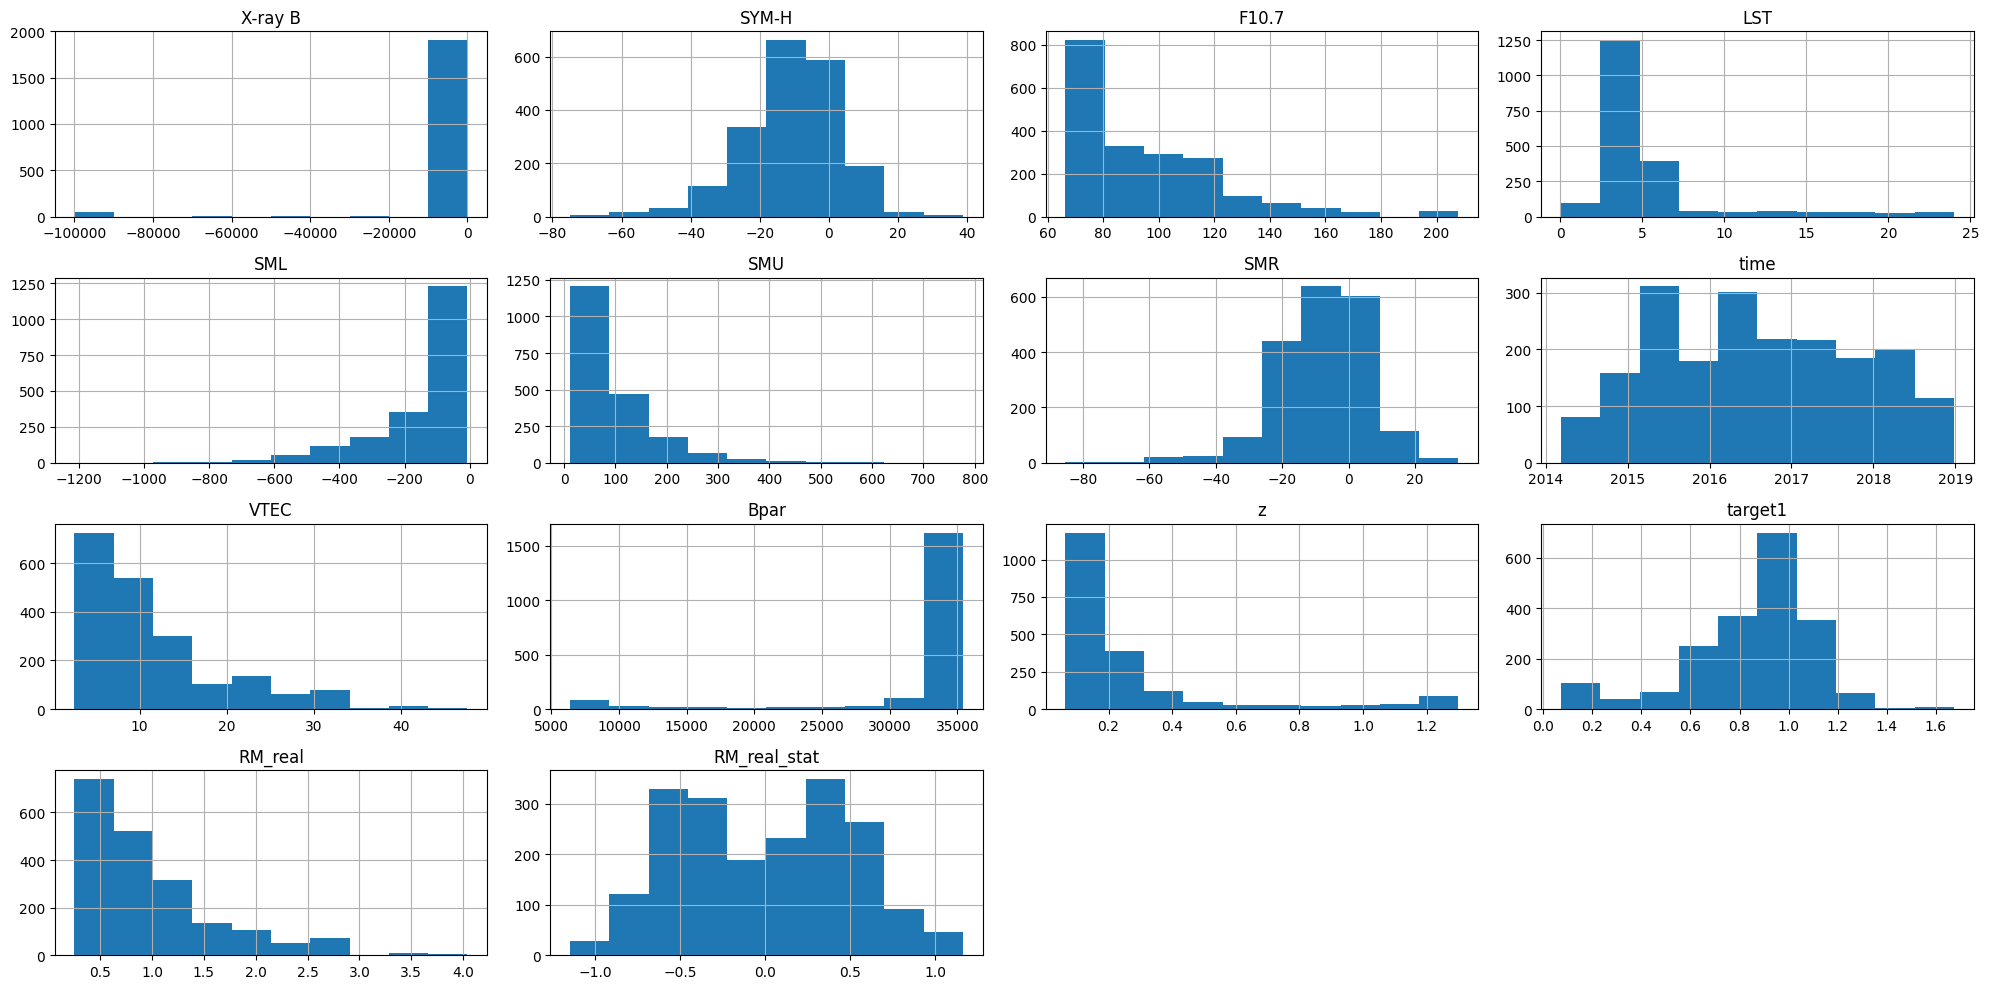

In [24]:
dataset.hist(figsize=(20, 10))
clear_output()
plt.tight_layout()
plt.show()

Let's clear the dataset of obvious outliers

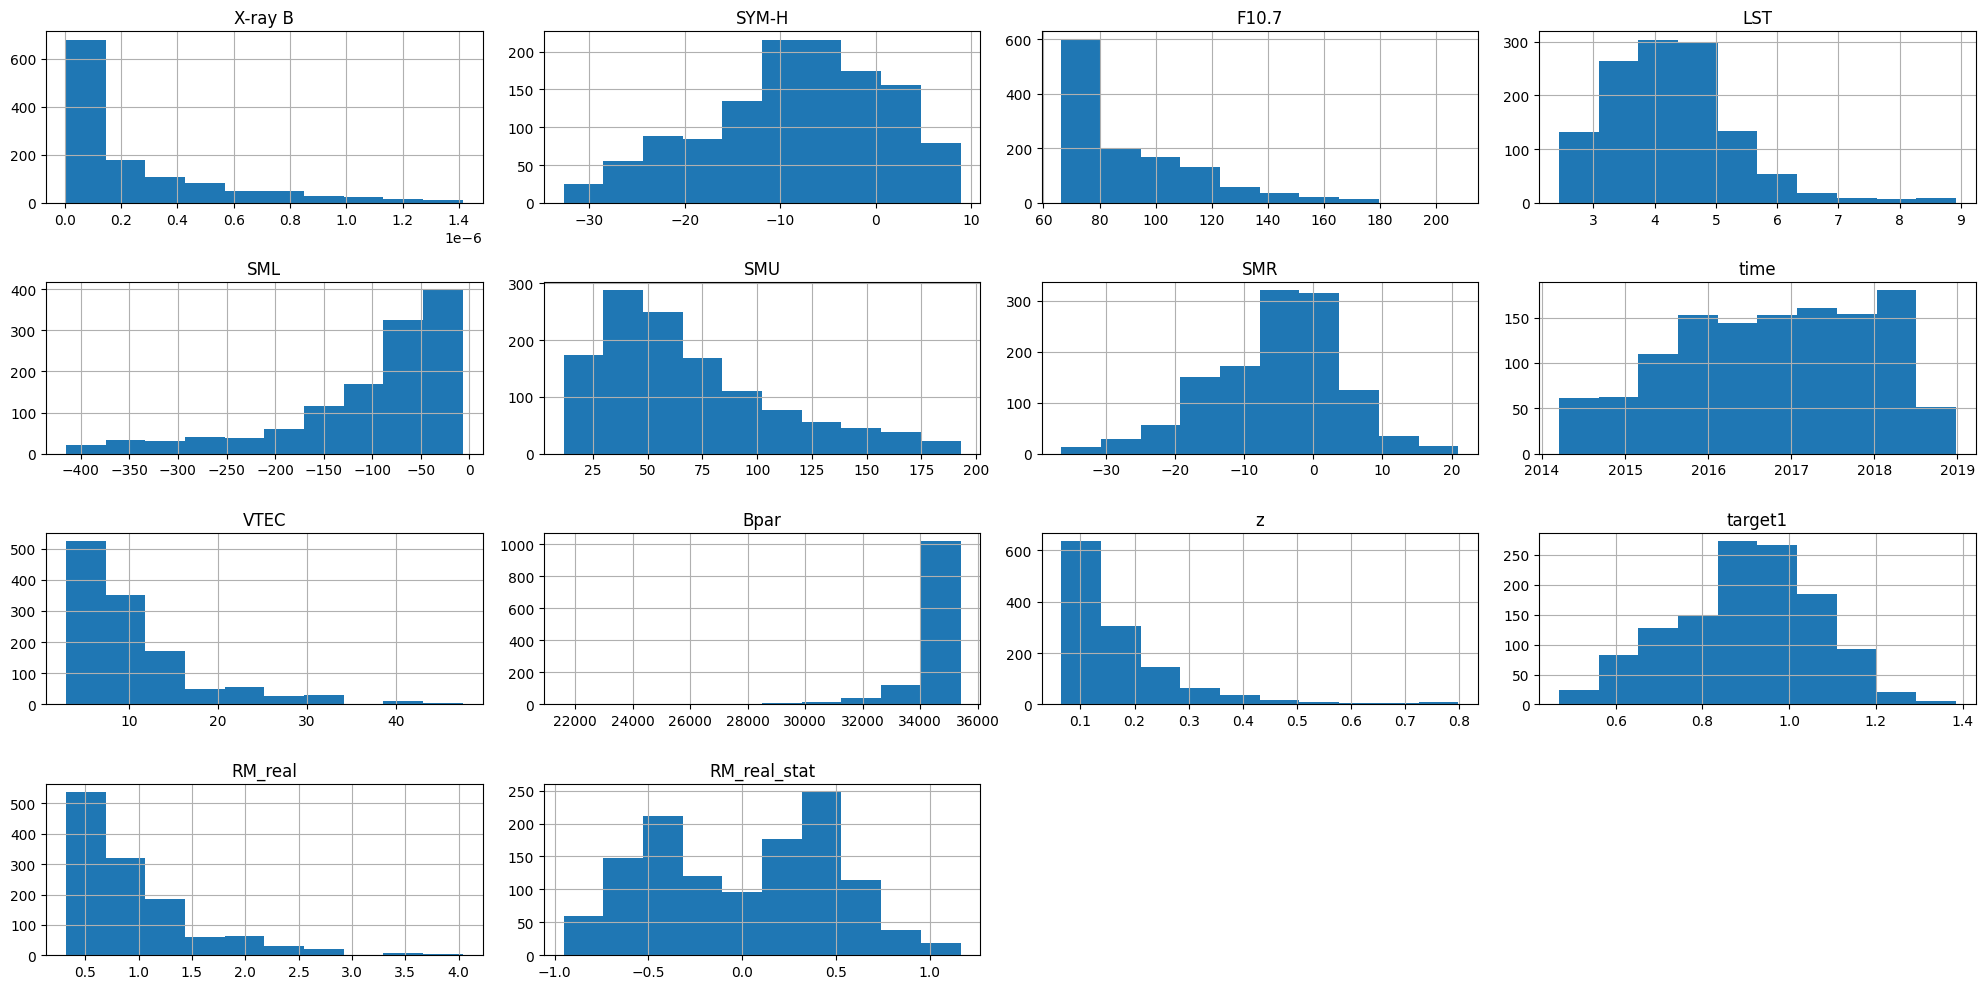

In [25]:
cleaned_dataset = dataset[dataset['X-ray B'] >= dataset['X-ray B'].quantile(0.05)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['X-ray B'] <= cleaned_dataset['X-ray B'].quantile(0.95)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['LST'] <= cleaned_dataset['LST'].quantile(0.9)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['LST'] >= cleaned_dataset['LST'].quantile(0.05)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['SYM-H'] >= cleaned_dataset['SYM-H'].quantile(0.05)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['SYM-H'] <= cleaned_dataset['SYM-H'].quantile(0.95)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['SML'] >= cleaned_dataset['SML'].quantile(0.05)]
cleaned_dataset = cleaned_dataset[cleaned_dataset['SMU'] <= cleaned_dataset['SMU'].quantile(0.95)]

cleaned_dataset.hist(figsize=(20, 10))
clear_output()
plt.tight_layout()
plt.show()

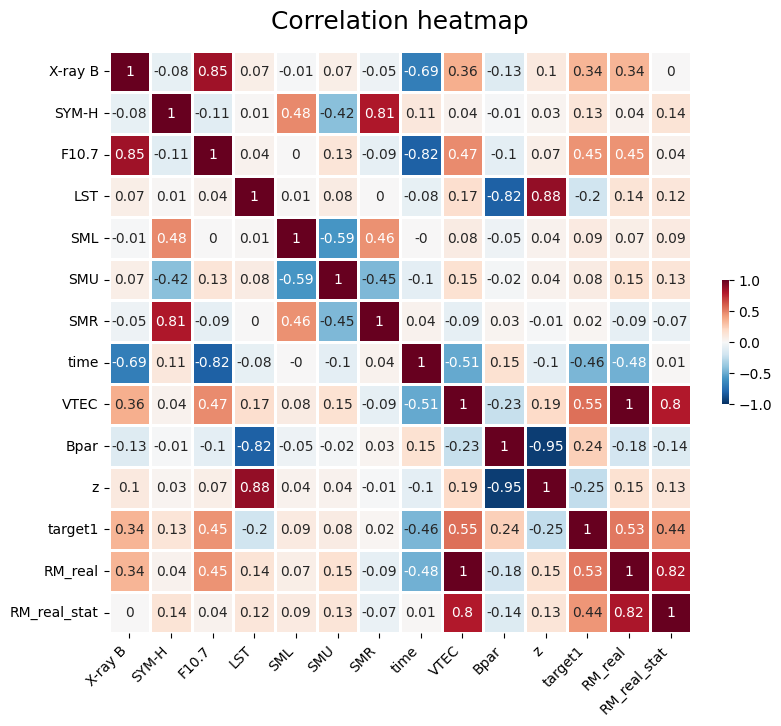

In [26]:
plt.figure(figsize=(8, 8))

heatmap = sns.heatmap(
    cleaned_dataset.corr(method="pearson", numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="RdBu_r",
    vmax=1,
    vmin=-1,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correlation heatmap", fontdict={"fontsize": 18}, pad=16)
clear_output()
plt.show()

Let's standardize the data that will be the input to the models

In [27]:
pulsar_features = cleaned_dataset[['time', 'RM_real', 'RM_real_stat', 'VTEC', 'Bpar', 'z', 'target1']]
features = cleaned_dataset.drop(columns=['time', 'RM_real', 'RM_real_stat', 'VTEC', 'Bpar', 'z', 'target1'])

features_scaled = RobustScaler().fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns.values, index = features.index.values)

dataset_scaled = pd.concat([features_scaled, pulsar_features], axis=1)

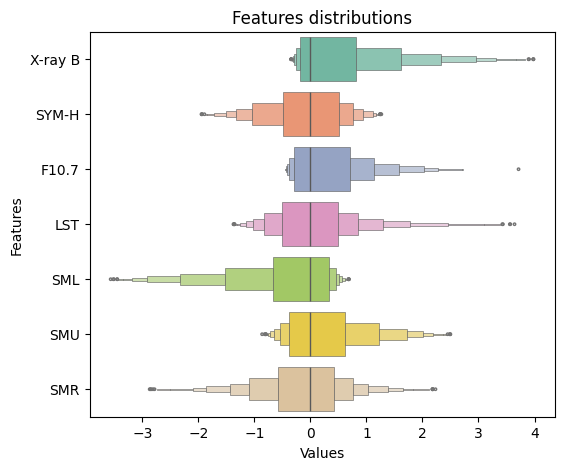

In [28]:
plt.figure(figsize=(6, 5))
ax = sns.boxenplot(
    data=features_scaled,
    orient="h",
    palette="Set2",
    linewidth=0.4,
    flier_kws={"marker": "o", "s": 3},
    line_kws={"linewidth": 1},
)
ax.set(xlabel="Values", ylabel="Features")
plt.title("Features distributions")
plt.show()

### Train-val-test split

We divide the dataset sequentially into training, validation and test datasets

In [29]:
total_rows = len(dataset_scaled)
train_rows = int(total_rows * 0.75)
val_rows = int(total_rows * 0.15)
test_rows = int(total_rows * 0.1)

train = dataset_scaled[:train_rows]
val = dataset_scaled[train_rows:train_rows+val_rows]
test = dataset_scaled[train_rows+val_rows:]

print("train", len(train))
print("val:", len(val))
print("test:", len(test))

train 922
val: 184
test: 124


The visualization:

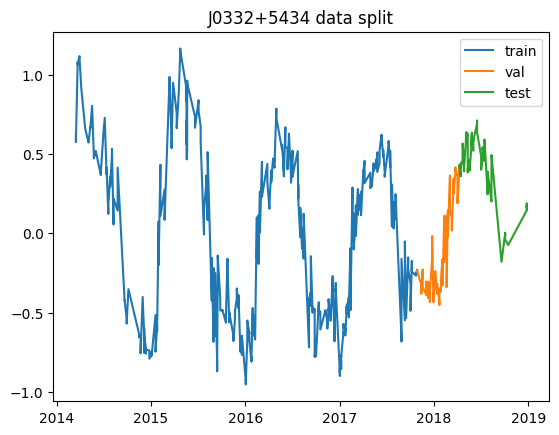

In [30]:
time_train = train['time']
RM_real_train = train['RM_real_stat']

time_val = val['time']
RM_real_val = val['RM_real_stat']

time_test = test['time']
RM_real_test = test['RM_real_stat']

plt.plot(time_train, RM_real_train, label='train')
plt.plot(time_val, RM_real_val, label='val')
plt.plot(time_test, RM_real_test, label='test')
plt.title("J0332+5434 data split")
plt.legend()
plt.show()

Be careful, datasets are not shuffled here

### Download data

Now one can save and then download the dataset

In [31]:
train.to_csv(puls_name+"_train.csv", header=None, index=None, sep=' ', mode='w')
val.to_csv(puls_name+"_val.csv", header=None, index=None, sep=' ', mode='w')
test.to_csv(puls_name+"_test.csv", header=None, index=None, sep=' ', mode='w')